# CNN + MaxPool
Fixed train/valid split.

Longest, GMM.

In [1]:
from datetime import datetime
print(datetime.now())

2023-03-11 19:56:39.153464


In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
print('GPU (if any):',device_name)

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    print('Running locally')
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print('Data directory:')
print(DATA_DIR)

GPU (if any): /device:GPU:0
Running on CoLab
Mounted at /content/drive/
Data directory:
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [3]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
CFILTERS=64
FILTERSIZE=16
RCELLS=32
DCELLS=16
EPOCHS=12
FOLDS=5      
EMBED_DIMEN = 4 # arbitrary hyperparameter
MINLEN=200
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'RCI_GMM'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
CACHING = False   # have not worked out how to cache multiple cell lines
NUM_LINES = 15   # 15 to analyze all of them

Python 3.9.16
sklearn 1.2.1


In [4]:
RCI_FILE       = 'train.lncRNA_RCI.csv'
SEQUENCE_FILE  = 'train.all_lncRNA_transcripts.csv'
CACHE_SEQUENCE = 'cache.seq.pickle'
CACHE_IDS      = 'cache.id.pickle'
if CACHING:
    cache_seq = DATA_DIR+CACHE_SEQUENCE 
    cache_ids = DATA_DIR+CACHE_IDS 
    if isfile(cache_seq) and isfile(cache_ids):
        print('WARNING: this run will read sequence from cache.')
    else:
        print('INFO: this run will write sequence to cache.')

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC

## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load from RCI csv file.
        Return dict with keys=gene:str and values=RCI:float.
        '''
        gene_to_rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = np.power(values,2)
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = 0.0
                        else:
                            log_mean = np.log2(big_mean) 
                        gene_to_rci[gene_id] = log_mean
        print('Number of RCI values loaded',len(gene_to_rci.keys()))
        return gene_to_rci

    def seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        allids=[]
        allseq=[]
        cache_seq = DATA_DIR+CACHE_SEQUENCE 
        cache_ids = DATA_DIR+CACHE_IDS 
        if CACHING and isfile(cache_seq) and isfile(cache_ids):
            # Warning: the cache may represent the wrong K.
            with open(cache_seq,'rb') as fin:
                allseq = pickle.load(fin)
            with open(cache_ids,'rb') as fin:
                allids = pickle.load(fin)
            return allids,allseq           
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # with version number
                    gene_id = fields[1]        # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    if seq_len>=MINLEN and seq_len<=MAXLEN and gene_id in gene_to_rci.keys():
                        allids.append( (gene_id,tran_id) )
                        if seq_len<MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                            seq_txt = seq_txt[:MAXLEN]
                        hot_vec = self.seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        if CACHING:
            with open(cache_seq,'wb') as fout:
                pickle.dump(allseq,fout)
            with open(cache_ids,'wb') as fout:
                pickle.dump(allids,fout)
        return allids,allseq

## Model

In [7]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    cnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    pool_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    flat_layer = Flatten()
    dens_layer = Dense(DCELLS)
    drop_layer = Dropout(0.5)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    cnn.add(embed_layer)
    cnn.add(cnn1_layer)
    cnn.add(pool_layer)
    cnn.add(flat_layer)
    cnn.add(dens_layer)
    cnn.add(drop_layer)
    cnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    cnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return cnn

In [8]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-03-11 19:57:16.795145
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4997, 4)           1028      
                                                                 
 conv1d (Conv1D)             (None, 4982, 64)          4160      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 621, 64)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 39744)             0         
                                                                 
 dense (Dense)               (None, 16)                635920    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                             

## Training

In [9]:
import gc
class CrossValidator():
    def __init__(self,epochs,folds,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.folds = folds
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False    
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def set_sequences(self, allids, allseq):
        # Keep IDs and sequences in same order.
        self.all_ids = allids  # pairs of (gene_id,tran_id)
        self.all_seqs = allseq  # may be vectors of K-mers
        genes = []
        for i in range(len(allids)):
            (one_gene,one_tran) = allids[i]
            genes.append(one_gene)
        self.all_genes = genes
            
    def set_rci_map(self, gene_to_rci):
        # The map is for fast lookup, not gene order.
        self.rci_map = gene_to_rci # map gene_id to RCI value
    
    def _get_gene_subset(self, sub_index):
        sub_genes = set()
        for index in sub_index:
            one_gene = self.all_genes[index]
            sub_genes.add(one_gene)
        return sub_genes   # this is a set: unordered with fast lookup
    
    def _get_X_y(self, gene_index, exclude_middle=False):
        # gene_index is ndarray with subset of indices of all_genes
        subsetX=[]
        subsetY=[]
        gene_subset = self._get_gene_subset(gene_index)
        for t in range(len(self.all_ids)):
            gene_id,tran_id = self.all_ids[t]
            if gene_id in gene_subset:
                oneX            = self.all_seqs[t]
                oneY            = self.rci_map[gene_id]
                if exclude_middle and oneY >= -2 and oneY <= 0:
                    # Exclude middle from train set only, for comparison to Yuan et al
                    continue
                subsetX.append(oneX)
                subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values):
        if self.mechanism == 'RCI_GMM':
            # The GMM is from sklearn not keras, so
            # would have to set its random_state separately. 
            gmm = GaussianMixture(n_components=2, verbose=0, 
                covariance_type='spherical', n_init=100) 
            gmm.fit(rci_values)
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def do_cross_validation(self,repetition):
        fold=0
        print()
        print(datetime.now())
        print('splitting')
        # KFold shuffles once before making the partitions
        splitter = KFold(n_splits=self.folds,shuffle=True) # random_state=42)
        splits = splitter.split(self.all_genes)
        splitter = None
        for train_index,valid_index in splits:
            fold += 1
            print('Repetition',repetition,'Fold',fold)
            X_train,y_rci = self._get_X_y(train_index) 
            self._prepare_threshold(y_rci)  # use train subset only!
            self._explain_threshold()
            y_train = self._apply_threshold(y_rci)
            X_valid,y_rci = self._get_X_y(valid_index)  
            y_valid = self._apply_threshold(y_rci) 
            y_rci = None
            cw = class_weight.compute_class_weight(
                'balanced', classes=[0,1], y=y_train)
            cwd = {0: cw[0], 1: cw[1]}

            model=build_model()
            print("FIT")
            print(datetime.now())
            history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
                class_weight=cwd, validation_data=(X_valid,y_valid) ) 
            
            print("PREDICT")
            print(datetime.now())
            yhat_pred=model.predict(X_valid, verbose=0)             
            yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

            print('train class weights 1:0 %5.2f:%5.2f' % (cwd[1],cwd[0]))
            self._show_sizes('Train',y_train)
            self._show_sizes('Valid',y_valid)
            self._show_sizes('Predict',yhat_classes)

            accuracy = accuracy_score(y_valid, yhat_classes)*100.
            precision = precision_score(y_valid, yhat_classes)*100.
            recall = recall_score(y_valid, yhat_classes)*100.
            f1 = f1_score(y_valid, yhat_classes)*100.
            prc_Y, prc_X, prc_bins = precision_recall_curve(y_valid, yhat_pred)
            auprc = auc(prc_X,prc_Y)*100.
            auroc = roc_auc_score(y_valid, yhat_pred)*100.
            mcc = matthews_corrcoef(y_valid, yhat_classes)

            if PRETTY_PICTURES:
                pd.DataFrame(history.history).plot(figsize=(8,5))
                plt.grid(True)
                plt.gca().set_ylim(0,1)
                plt.show()

                print("Compute valiation accuracy")
                print('Valid sizes',X_valid.shape,y_valid.shape)
                print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
                print('Score threshold',self.score_threshold)

                count_ones= len(y_valid[y_valid==1])
                count_zeros= len(y_valid[y_valid==0])
                guess = max(count_ones,count_zeros) / len(y_valid)
                plt.plot(prc_X, prc_Y, marker='.')
                plt.plot([0, 1], [guess,guess], linestyle='--')
                plt.xlabel('Recall')
                plt.ylabel('Precision')
                plt.show()
                # ROC
                fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
                plt.plot(fpr, tpr, marker='.')
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.show()

            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.2f%%' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
            self.cv_accuracy.append(accuracy)
            self.cv_precision.append(precision)
            self.cv_recall.append(recall)
            self.cv_f1.append(f1)
            self.cv_mcc.append(mcc)
            self.cv_auprc.append(auprc)
            self.cv_auroc.append(auroc)
            
            print(datetime.now())
            if self.quick_test:   
                print('Break -- this was for code testing only')
                break

            # There is a memory leak within the fit() command!
            # Each successive call to fit() consumes more memory.
            model = None
            history = None
            prc_Y = None
            prc_X = None
            prc_bins = None
            yhat_classes = None
            X_train = None
            y_train = None
            X_valid = None
            y_valid = None
            tf.keras.backend.clear_session()
            gc.collect()
            time.sleep(1)  # hope gc kicks in
        print()

        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


2023-03-11 19:57:17.238478
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence...
Loaded 19301 sequences.
Cross validation...

2023-03-11 19:57:51.949680
splitting
Repetition 1 Fold 1
Discriminator is GMM
Means [1.422604189025539, -0.18315516285785943]
Variances [2.3807412  7.85947581]
Priors [0.73057072 0.26942928]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
FIT
2023-03-11 19:58:13.053412
PREDICT
2023-03-11 20:00:15.218909
train class weights 1:0  0.56: 4.74
Train 1:0 16822:1983 89.45%
Valid 1:0 13512:1628 89.25%
Predict 1:0 13318:1822 87.97%


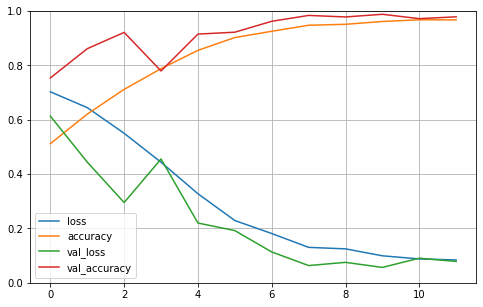

Compute valiation accuracy
Valid sizes (15140, 4997) (15140,)
Range of scores: 1.0753512e-37 to 1.0
Score threshold 0.5


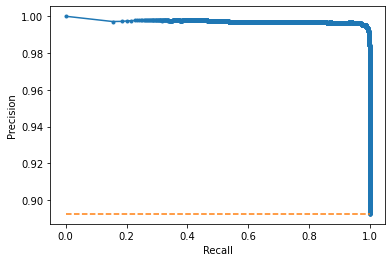

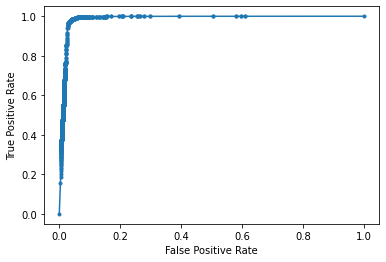

Accuracy: 97.86% Precision: 99.51% Recall: 98.08%
F1: 98.79% MCC: 0.90%
AUPRC: 99.73% AUROC: 98.65%
2023-03-11 20:00:19.246950
Repetition 1 Fold 2
Discriminator is GMM
Means [1.4118107247431824, -0.18720721916517008]
Variances [2.37392092 7.92977659]
Priors [0.73266002 0.26733998]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
FIT
2023-03-11 20:00:44.189391
PREDICT
2023-03-11 20:03:08.135683
train class weights 1:0  0.56: 4.75
Train 1:0 16809:1979 89.47%
Valid 1:0 13555:1541 89.79%
Predict 1:0 11469:3627 75.97%


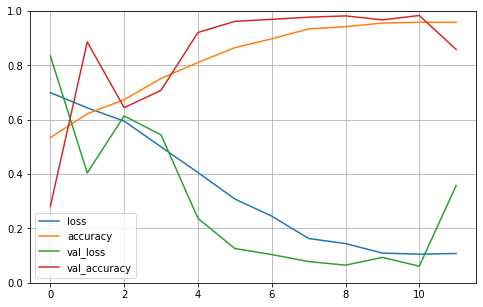

Compute valiation accuracy
Valid sizes (15096, 4997) (15096,)
Range of scores: 0.0 to 1.0
Score threshold 0.5


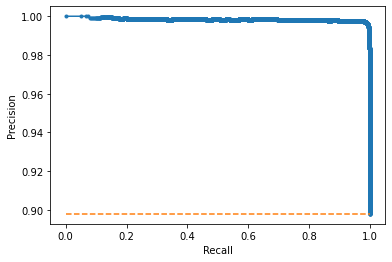

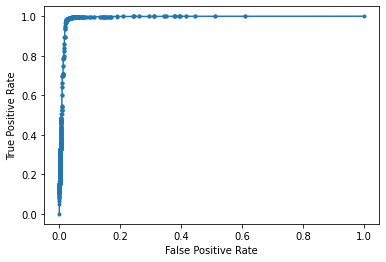

Accuracy: 85.85% Precision: 99.78% Recall: 84.43%
F1: 91.46% MCC: 0.59%
AUPRC: 99.84% AUROC: 99.10%
2023-03-11 20:03:13.368890
Repetition 1 Fold 3
Discriminator is GMM
Means [1.4186125128719473, -0.16559547100642294]
Variances [2.38143749 7.88971135]
Priors [0.73152598 0.26847402]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
FIT
2023-03-11 20:03:35.362869
PREDICT
2023-03-11 20:05:59.691547
train class weights 1:0  0.56: 4.75
Train 1:0 16795:1977 89.47%
Valid 1:0 13552:1513 89.96%
Predict 1:0 13318:1747 88.40%


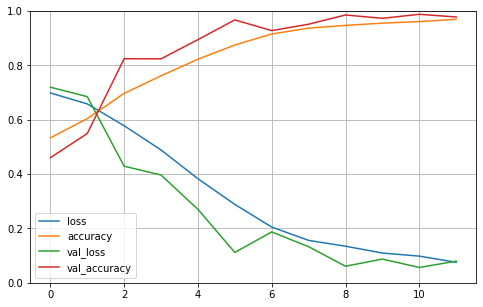

Compute valiation accuracy
Valid sizes (15065, 4997) (15065,)
Range of scores: 0.0 to 1.0
Score threshold 0.5


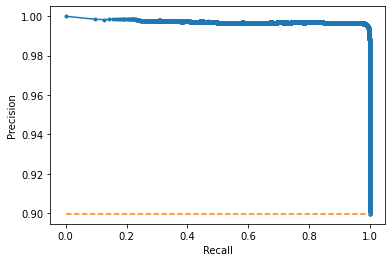

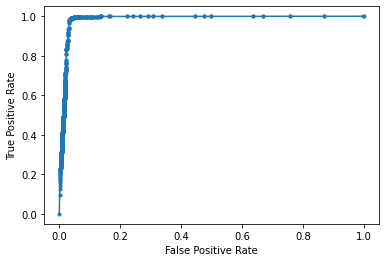

Accuracy: 97.80% Precision: 99.63% Recall: 97.91%
F1: 98.76% MCC: 0.89%
AUPRC: 99.73% AUROC: 98.54%
2023-03-11 20:06:04.151189
Repetition 1 Fold 4
Discriminator is GMM
Means [1.4129084363388007, -0.17187066314937627]
Variances [2.38501552 7.88687824]
Priors [0.73037915 0.26962085]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
FIT
2023-03-11 20:06:26.711252
PREDICT
2023-03-11 20:08:50.708660
train class weights 1:0  0.56: 4.74
Train 1:0 16800:1982 89.45%
Valid 1:0 13657:1466 90.31%
Predict 1:0 13303:1820 87.97%


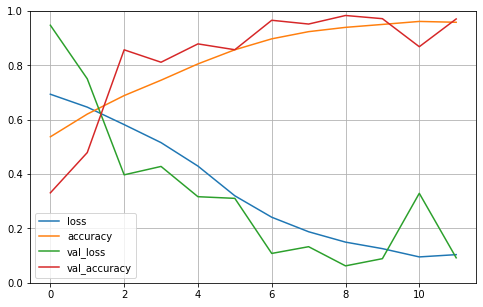

Compute valiation accuracy
Valid sizes (15123, 4997) (15123,)
Range of scores: 3.811712e-36 to 1.0
Score threshold 0.5


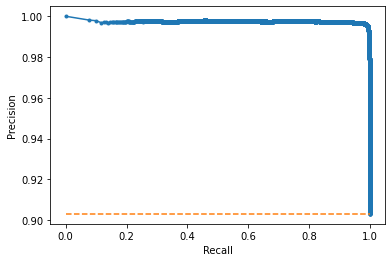

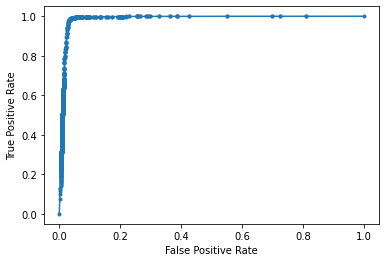

Accuracy: 97.08% Precision: 99.67% Recall: 97.09%
F1: 98.36% MCC: 0.86%
AUPRC: 99.75% AUROC: 98.70%
2023-03-11 20:08:54.542836
Repetition 1 Fold 5
Discriminator is GMM
Means [-0.1783032502947568, 1.420926502853912]
Variances [7.85728666 2.37972526]
Priors [0.26796897 0.73203103]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
FIT
2023-03-11 20:09:19.147114
PREDICT
2023-03-11 20:11:43.179292
train class weights 1:0  0.56: 4.75
Train 1:0 16807:1975 89.48%
Valid 1:0 13427:1515 89.86%
Predict 1:0 12998:1944 86.99%


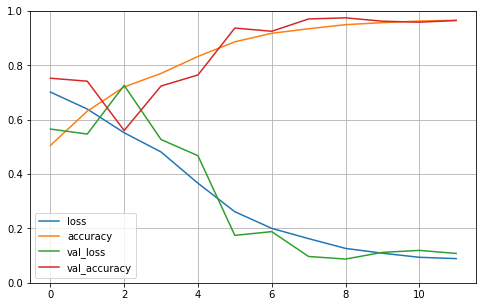

Compute valiation accuracy
Valid sizes (14942, 4997) (14942,)
Range of scores: 2.1374937e-34 to 1.0
Score threshold 0.5


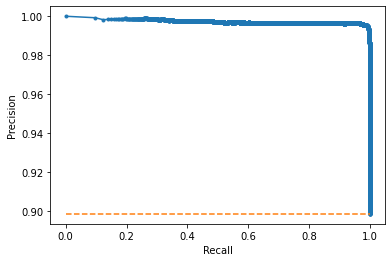

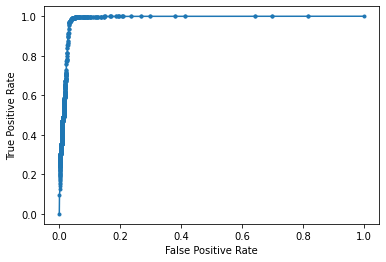

Accuracy: 96.50% Precision: 99.64% Recall: 96.45%
F1: 98.02% MCC: 0.84%
AUPRC: 99.74% AUROC: 98.55%
2023-03-11 20:11:47.282133


2023-03-11 20:11:48.984954
splitting
Repetition 2 Fold 1
Discriminator is GMM
Means [1.4217489273588086, -0.1579740880951341]
Variances [2.38448815 7.745185  ]
Priors [0.72865301 0.27134699]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
FIT
2023-03-11 20:12:13.392204
PREDICT
2023-03-11 20:13:54.733174
train class weights 1:0  0.56: 4.71
Train 1:0 16777:1994 89.38%
Valid 1:0 13468:1552 89.67%
Predict 1:0 13411:1609 89.29%


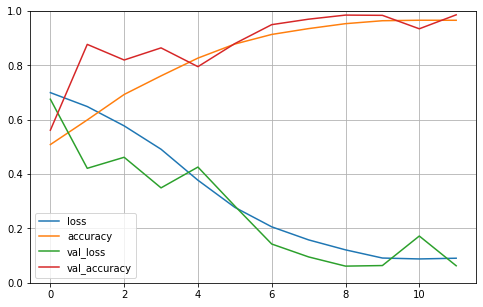

Compute valiation accuracy
Valid sizes (15020, 4997) (15020,)
Range of scores: 0.0 to 1.0
Score threshold 0.5


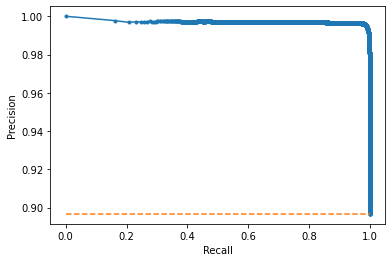

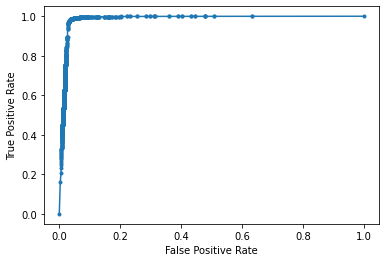

Accuracy: 98.60% Precision: 99.43% Recall: 99.01%
F1: 99.22% MCC: 0.93%
AUPRC: 99.72% AUROC: 98.56%
2023-03-11 20:14:01.688344
Repetition 2 Fold 2
Discriminator is GMM
Means [1.4134020321106775, -0.18869108939750076]
Variances [2.37644128 7.95987566]
Priors [0.73372116 0.26627884]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
FIT
2023-03-11 20:14:25.287986
PREDICT
2023-03-11 20:16:49.398430
train class weights 1:0  0.56: 4.80
Train 1:0 16827:1956 89.59%
Valid 1:0 13623:1565 89.70%
Predict 1:0 13284:1904 87.46%


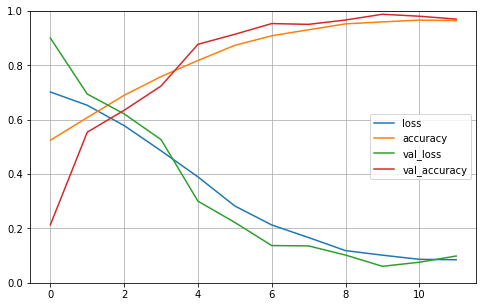

Compute valiation accuracy
Valid sizes (15188, 4997) (15188,)
Range of scores: 0.0 to 1.0
Score threshold 0.5


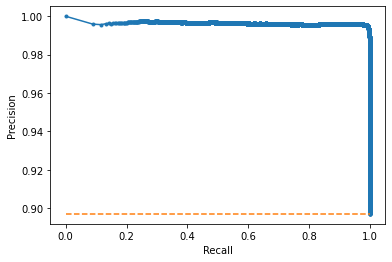

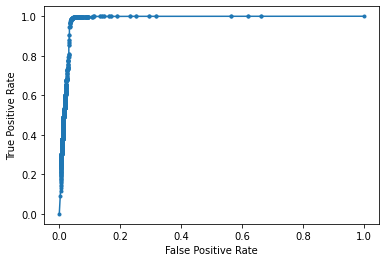

Accuracy: 97.02% Precision: 99.57% Recall: 97.09%
F1: 98.32% MCC: 0.86%
AUPRC: 99.64% AUROC: 98.26%
2023-03-11 20:16:53.236314
Repetition 2 Fold 3
Discriminator is GMM
Means [1.421065218217563, -0.17044290280961663]
Variances [2.37472907 7.80223376]
Priors [0.72936115 0.27063885]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
FIT
2023-03-11 20:17:17.222149
PREDICT
2023-03-11 20:19:01.203143
train class weights 1:0  0.56: 4.69
Train 1:0 16765:1999 89.35%
Valid 1:0 13527:1589 89.49%
Predict 1:0 13426:1690 88.82%


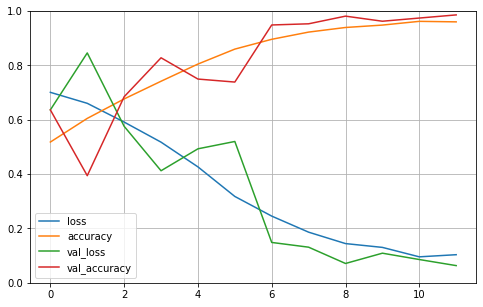

Compute valiation accuracy
Valid sizes (15116, 4997) (15116,)
Range of scores: 1.1343422e-30 to 1.0
Score threshold 0.5


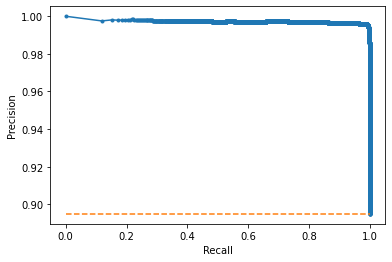

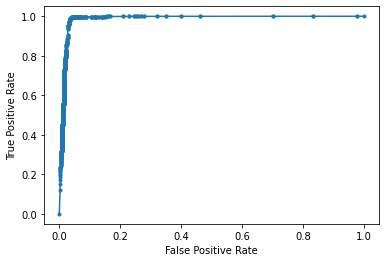

Accuracy: 98.56% Precision: 99.57% Recall: 98.82%
F1: 99.19% MCC: 0.93%
AUPRC: 99.73% AUROC: 98.66%
2023-03-11 20:19:05.392881
Repetition 2 Fold 4
Discriminator is GMM
Means [1.421938646225618, -0.18869830933730666]
Variances [2.37607754 7.87281427]
Priors [0.73100301 0.26899699]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
FIT
2023-03-11 20:19:28.080729
PREDICT
2023-03-11 20:21:52.611395
train class weights 1:0  0.56: 4.72
Train 1:0 16770:1989 89.40%
Valid 1:0 13641:1563 89.72%
Predict 1:0 13588:1616 89.37%


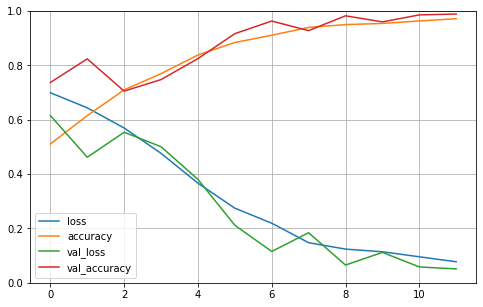

Compute valiation accuracy
Valid sizes (15204, 4997) (15204,)
Range of scores: 7.5636475e-30 to 1.0
Score threshold 0.5


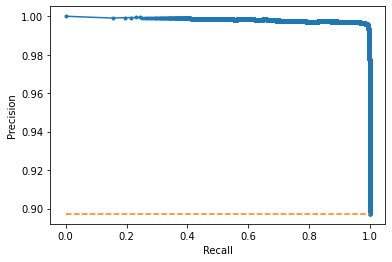

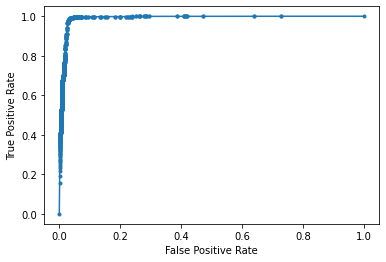

Accuracy: 98.88% Precision: 99.57% Recall: 99.18%
F1: 99.37% MCC: 0.94%
AUPRC: 99.83% AUROC: 98.99%
2023-03-11 20:21:56.903199
Repetition 2 Fold 5
Discriminator is GMM
Means [1.4134326584375685, -0.18841444894178244]
Variances [2.38367471 7.96570554]
Priors [0.73336985 0.26663015]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
FIT
2023-03-11 20:22:21.796166
PREDICT
2023-03-11 20:24:45.794579
train class weights 1:0  0.56: 4.78
Train 1:0 16841:1969 89.53%
Valid 1:0 13462:1543 89.72%
Predict 1:0 13414:1591 89.40%


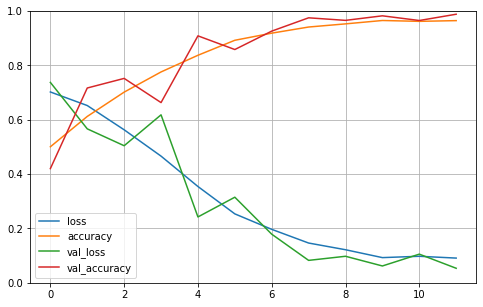

Compute valiation accuracy
Valid sizes (15005, 4997) (15005,)
Range of scores: 0.0 to 1.0
Score threshold 0.5


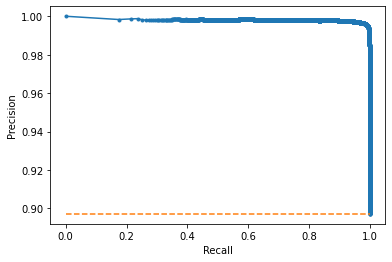

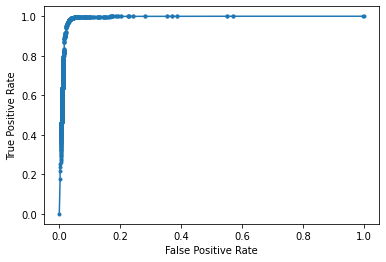

Accuracy: 98.81% Precision: 99.52% Recall: 99.16%
F1: 99.34% MCC: 0.94%
AUPRC: 99.81% AUROC: 99.01%
2023-03-11 20:24:49.916287

Completed cross validation 5 folds 12 epochs
Repeated for a total of 10 folds
 accuracy mean 96.69% std 3.90
 precision mean 99.59% std 0.10
 recall mean 96.72% std 4.43
 F1 mean 98.08% std 2.37
 MCC mean 0.87% std 0.10
 AUPRC mean 99.75% std 0.06
 AUROC mean 98.70% std 0.26

 accuracy [97.85997357992075, 85.85055643879174, 97.79621639561898, 97.07729947761688, 96.49979922366484, 98.59520639147803, 97.01738214379773, 98.56443503572375, 98.8752959747435, 98.81372875708098]
 precision [99.51193872953897, 99.78202110035748, 99.63207688842168, 99.66924753814929, 99.63840590860133, 99.42584445604355, 99.57091237579043, 99.56800238343513, 99.56579334707094, 99.51543163858655]
 recall [98.08318531675548, 84.42641091848027, 97.91174734356552, 97.08574357472358, 96.45490429731139, 99.005049005049, 97.0931512882625, 98.82457307607008, 99.17894582508615, 99.1606002079928

In [10]:
print(datetime.now())
loader = DataLoader()
filepath = DATA_DIR+RCI_FILE
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
print('Load sequence...')
filepath = DATA_DIR+SEQUENCE_FILE
allids,allseq = loader.load_sequence(filepath)
print('Loaded',len(allseq),'sequences.')
loader = None  # drop K-mer cache to save RAM

print("Cross validation...")
cvdo = CrossValidator(EPOCHS,FOLDS,BREAK)
cvdo.set_sequences(allids,allseq)
cvdo.set_rci_map(gene_to_rci)
cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
# two rounds of 5 for 10 total
total_folds = 0
for F in range(2):
    total_folds += FOLDS
    cvdo.do_cross_validation(F+1)   
cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
    cvdo.get_statistics()
cvdo = None

def STD (values):
    return np.std(values,ddof=1)

print("Completed cross validation %d folds %d epochs" % (FOLDS,EPOCHS)) 
print("Repeated for a total of %d folds" % total_folds)
print(" accuracy mean %.2f%% std %.2f" %  (np.mean(cv_accuracy),  STD(cv_accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(cv_precision), STD(cv_precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(cv_recall),    STD(cv_recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(cv_f1),        STD(cv_f1)))
print(" MCC mean %.2f%% std %.2f" %       (np.mean(cv_mcc),       STD(cv_mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(cv_auprc),     STD(cv_auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(cv_auroc),     STD(cv_auroc)))
print()
print(" accuracy" ,  cv_accuracy)
print(" precision" , cv_precision)
print(" recall" ,    cv_recall)
print(" F1" ,        cv_f1)
print(" MCC" ,       cv_mcc)
print(" AUPRC" ,     cv_auprc)
print(" AUROC" ,     cv_auroc)
print(datetime.now())